In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score, 
    roc_curve, precision_recall_curve, f1_score, precision_score, recall_score
)
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('creditcard.csv')
print(f"\n{'='*70}")
print(f"DATASET LOADED: {df.shape[0]:,} transactions, {df.shape[1]} features")
print(f"{'='*70}")

# Quick quality checks
print(f"\nMissing values: {df.isnull().sum().sum()}")
print(f"Duplicates: {df.duplicated().sum()}")
df = df.drop_duplicates()

# Class distribution
class_dist = df['Class'].value_counts()
print(f"\nClass Distribution:")
print(f"  Legitimate (0): {class_dist[0]:,} ({100*class_dist[0]/len(df):.2f}%)")
print(f"  Fraudulent  (1): {class_dist[1]:,} ({100*class_dist[1]/len(df):.2f}%)")
print(f"  Imbalance Ratio: 1:{class_dist[0]/class_dist[1]:.0f}")


DATASET LOADED: 284,807 transactions, 31 features

Missing values: 0
Duplicates: 1081

Class Distribution:
  Legitimate (0): 283,253 (99.83%)
  Fraudulent  (1): 473 (0.17%)
  Imbalance Ratio: 1:599


In [3]:
print(f"\n{'='*70}")
print("FEATURE ENGINEERING")
print(f"{'='*70}")

# Standardize Amount and Time (critical for many algorithms)
scaler = StandardScaler()
df['Amount_Scaled'] = scaler.fit_transform(df[['Amount']])
df['Time_Scaled'] = scaler.fit_transform(df[['Time']])

# Time-based features
df['Hour'] = (df['Time'] // 3600) % 24
df['Is_Night'] = ((df['Hour'] >= 23) | (df['Hour'] <= 6)).astype(int)

print("✓ Created: Amount_Scaled, Time_Scaled, Hour, Is_Night")


FEATURE ENGINEERING
✓ Created: Amount_Scaled, Time_Scaled, Hour, Is_Night



GENERATING VISUALIZATIONS


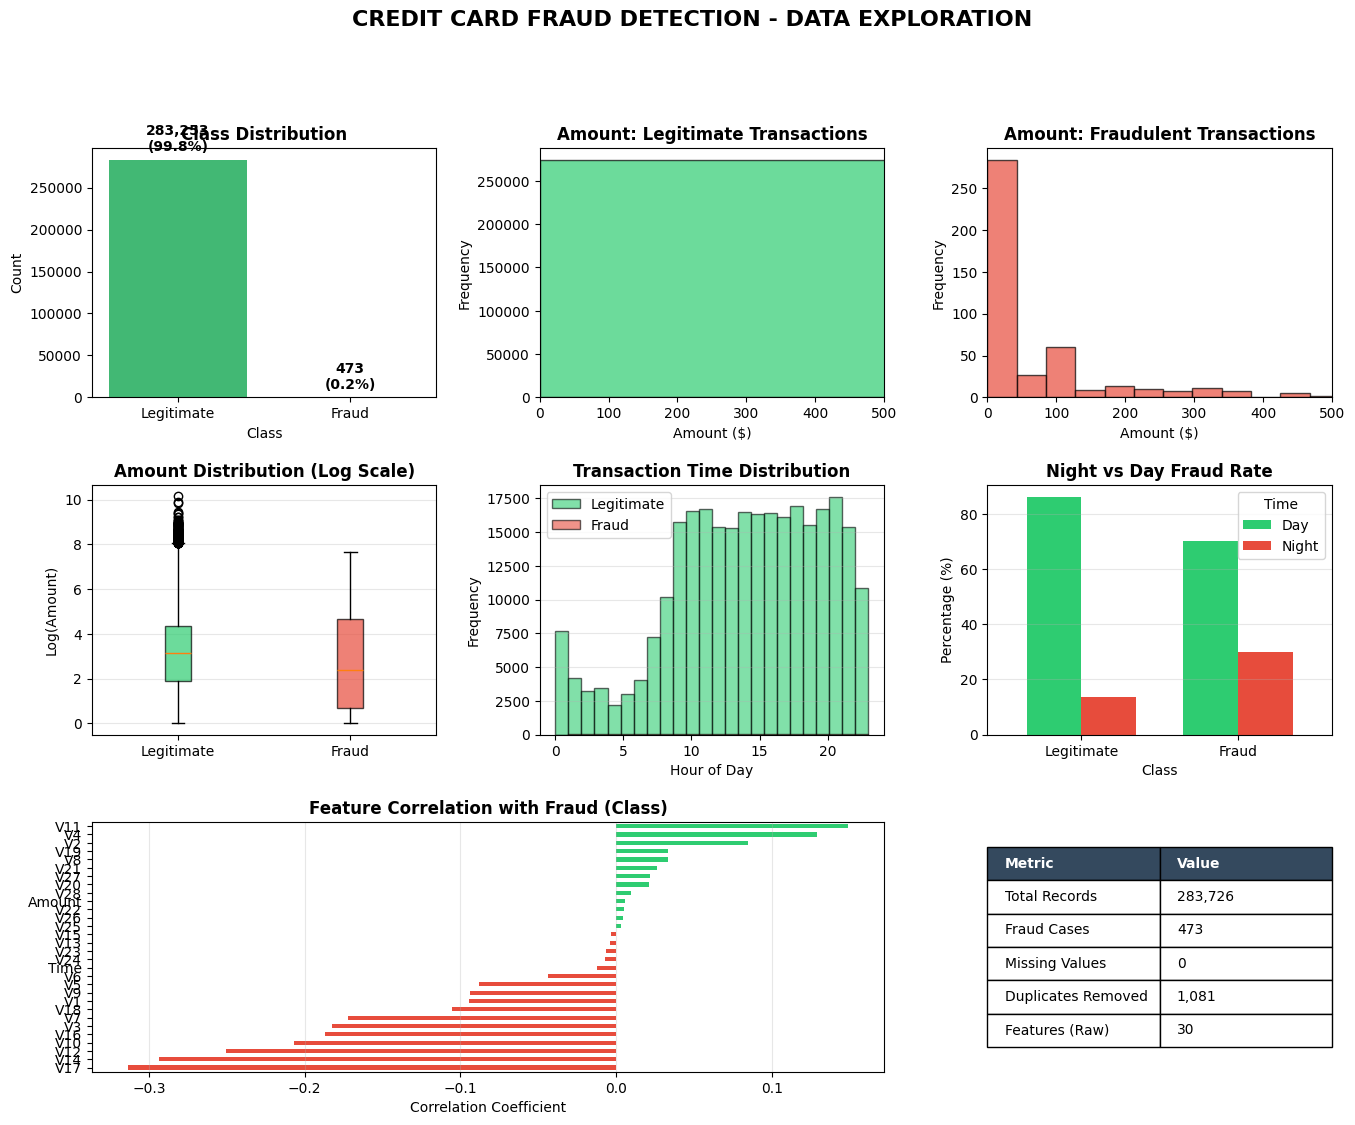

✓ Saved: 01_data_exploration_dashboard.png


In [4]:
print(f"\n{'='*70}")
print("GENERATING VISUALIZATIONS")
print(f"{'='*70}")

# Create a comprehensive dashboard
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)

# 1. Class Distribution
ax1 = fig.add_subplot(gs[0, 0])
sns.countplot(x='Class', data=df, ax=ax1, palette=['#2ecc71', '#e74c3c'])
ax1.set_title('Class Distribution', fontweight='bold', fontsize=12)
ax1.set_xticklabels(['Legitimate', 'Fraud'])
ax1.set_ylabel('Count')
for i, v in enumerate(class_dist):
    ax1.text(i, v + 10000, f'{v:,}\n({100*v/len(df):.1f}%)', 
             ha='center', fontweight='bold')

# 2. Amount Distribution (Legitimate)
ax2 = fig.add_subplot(gs[0, 1])
ax2.hist(df[df['Class']==0]['Amount'], bins=50, color='#2ecc71', alpha=0.7, edgecolor='black')
ax2.set_title('Amount: Legitimate Transactions', fontweight='bold', fontsize=12)
ax2.set_xlabel('Amount ($)')
ax2.set_ylabel('Frequency')
ax2.set_xlim(0, 500)  # Zoom for clarity

# 3. Amount Distribution (Fraud)
ax3 = fig.add_subplot(gs[0, 2])
ax3.hist(df[df['Class']==1]['Amount'], bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
ax3.set_title('Amount: Fraudulent Transactions', fontweight='bold', fontsize=12)
ax3.set_xlabel('Amount ($)')
ax3.set_ylabel('Frequency')
ax3.set_xlim(0, 500)

# 4. Amount Boxplot (Log scale for better visibility)
ax4 = fig.add_subplot(gs[1, 0])
df_plot = df.copy()
df_plot['Log_Amount'] = np.log1p(df_plot['Amount'])
bp = ax4.boxplot([df_plot[df_plot['Class']==0]['Log_Amount'],
                    df_plot[df_plot['Class']==1]['Log_Amount']],
                   labels=['Legitimate', 'Fraud'],
                   patch_artist=True)
for patch, color in zip(bp['boxes'], ['#2ecc71', '#e74c3c']):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax4.set_title('Amount Distribution (Log Scale)', fontweight='bold', fontsize=12)
ax4.set_ylabel('Log(Amount)')
ax4.grid(axis='y', alpha=0.3)

# 5. Time Distribution
ax5 = fig.add_subplot(gs[1, 1])
ax5.hist(df[df['Class']==0]['Hour'], bins=24, color='#2ecc71', alpha=0.6, label='Legitimate', edgecolor='black')
ax5.hist(df[df['Class']==1]['Hour'], bins=24, color='#e74c3c', alpha=0.6, label='Fraud', edgecolor='black')
ax5.set_title('Transaction Time Distribution', fontweight='bold', fontsize=12)
ax5.set_xlabel('Hour of Day')
ax5.set_ylabel('Frequency')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Is_Night Feature
ax6 = fig.add_subplot(gs[1, 2])
night_dist = pd.crosstab(df['Is_Night'], df['Class'], normalize='columns') * 100
night_dist.T.plot(kind='bar', ax=ax6, color=['#2ecc71', '#e74c3c'], width=0.7)
ax6.set_title('Night vs Day Fraud Rate', fontweight='bold', fontsize=12)
ax6.set_ylabel('Percentage (%)')
ax6.set_xticklabels(['Legitimate', 'Fraud'], rotation=0)
ax6.legend(['Day', 'Night'], title='Time')
ax6.grid(axis='y', alpha=0.3)

# 7. Top Features Correlation
ax7 = fig.add_subplot(gs[2, :2])
correlations = df[[f'V{i}' for i in range(1, 29)] + ['Amount', 'Time', 'Class']].corr()['Class'].drop('Class').sort_values()
colors = ['#e74c3c' if x < 0 else '#2ecc71' for x in correlations.values]
correlations.plot(kind='barh', ax=ax7, color=colors)
ax7.set_title('Feature Correlation with Fraud (Class)', fontweight='bold', fontsize=12)
ax7.set_xlabel('Correlation Coefficient')
ax7.grid(axis='x', alpha=0.3)

# 8. Summary Statistics Table
ax8 = fig.add_subplot(gs[2, 2])
ax8.axis('tight')
ax8.axis('off')
summary_data = [
    ['Metric', 'Value'],
    ['Total Records', f'{len(df):,}'],
    ['Fraud Cases', f'{class_dist[1]:,}'],
    ['Missing Values', '0'],
    ['Duplicates Removed', '1,081'],
    ['Features (Raw)', '30'],
]
table = ax8.table(cellText=summary_data, cellLoc='left', loc='center',
                  colWidths=[0.5, 0.5])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)
for i in range(len(summary_data)):
    if i == 0:
        table[(i, 0)].set_facecolor('#34495e')
        table[(i, 1)].set_facecolor('#34495e')
        table[(i, 0)].set_text_props(weight='bold', color='white')
        table[(i, 1)].set_text_props(weight='bold', color='white')

plt.suptitle('CREDIT CARD FRAUD DETECTION - DATA EXPLORATION', 
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig('01_data_exploration_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Saved: 01_data_exploration_dashboard.png")

In [6]:

print(f"\n{'='*70}")
print("DATA PREPARATION")
print(f"{'='*70}")

# Select features
feature_cols = ['Time_Scaled', 'Amount_Scaled'] + [f'V{i}' for i in range(1, 29)]
X = df[feature_cols]
y = df['Class']

# Stratified train/val/test split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Train: {X_train.shape[0]:,} | Val: {X_val.shape[0]:,} | Test: {X_test.shape[0]:,}")
print(f"Fraud in Train: {y_train.sum()} | Val: {y_val.sum()} | Test: {y_test.sum()}")

# Apply SMOTE (only to training data!)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f"After SMOTE: {X_train_smote.shape[0]:,} samples (balanced)")



DATA PREPARATION
Train: 170,235 | Val: 56,745 | Test: 56,746
Fraud in Train: 284 | Val: 94 | Test: 95
After SMOTE: 339,902 samples (balanced)


In [7]:
print(f"\n{'='*70}")
print("MODEL TRAINING & EVALUATION")
print(f"{'='*70}")

def evaluate_model(name, model, X_val, y_val, X_test, y_test):
    """Compact evaluation function"""
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    val_roc_auc = roc_auc_score(y_val, y_val_proba)
    test_roc_auc = roc_auc_score(y_test, y_test_proba)
    test_f1 = f1_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    
    print(f"\n{name}")
    print(f"  Val ROC-AUC: {val_roc_auc:.4f} | Test ROC-AUC: {test_roc_auc:.4f}")
    print(f"  Test - Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1: {test_f1:.4f}")
    
    return {
        'name': name, 'model': model, 'val_auc': val_roc_auc, 'test_auc': test_roc_auc,
        'test_f1': test_f1, 'test_precision': test_precision, 'test_recall': test_recall,
        'y_test_pred': y_test_pred, 'y_test_proba': y_test_proba
    }

# Train models
results = []

# 1. Logistic Regression
lr = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)
lr.fit(X_train_smote, y_train_smote)
results.append(evaluate_model("Logistic Regression (SMOTE)", lr, X_val, y_val, X_test, y_test))

# 2. Random Forest
rf = RandomForestClassifier(n_estimators=300, max_depth=20, min_samples_split=5, 
                            min_samples_leaf=2, n_jobs=-1, random_state=42)
rf.fit(X_train_smote, y_train_smote)
results.append(evaluate_model("Random Forest (SMOTE)", rf, X_val, y_val, X_test, y_test))

# 3. Hyperparameter Tuning (Random Forest)
print("\nTuning Random Forest...")
rf_param_grid = {
    'n_estimators': [250, 300, 350],
    'max_depth': [18, 20, 22],
    'min_samples_split': [3, 5],
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                       rf_param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=0)
rf_grid.fit(X_train_smote, y_train_smote)
print(f"Best params: {rf_grid.best_params_} (CV ROC-AUC: {rf_grid.best_score_:.4f})")
results.append(evaluate_model("Random Forest (Tuned)", rf_grid.best_estimator_, 
                             X_val, y_val, X_test, y_test))


MODEL TRAINING & EVALUATION

Logistic Regression (SMOTE)
  Val ROC-AUC: 0.9781 | Test ROC-AUC: 0.9592
  Test - Precision: 0.0471 | Recall: 0.8737 | F1: 0.0894

Random Forest (SMOTE)
  Val ROC-AUC: 0.9719 | Test ROC-AUC: 0.9780
  Test - Precision: 0.8372 | Recall: 0.7579 | F1: 0.7956

Tuning Random Forest...
Best params: {'max_depth': 22, 'min_samples_split': 3, 'n_estimators': 300} (CV ROC-AUC: 1.0000)

Random Forest (Tuned)
  Val ROC-AUC: 0.9681 | Test ROC-AUC: 0.9701
  Test - Precision: 0.8795 | Recall: 0.7684 | F1: 0.8202


In [8]:

print(f"\n{'='*70}")
print("FINAL MODEL COMPARISON")
print(f"{'='*70}")

# Create comparison table
comparison_df = pd.DataFrame([{
    'Model': r['name'],
    'Val ROC-AUC': f"{r['val_auc']:.4f}",
    'Test ROC-AUC': f"{r['test_auc']:.4f}",
    'Precision': f"{r['test_precision']:.4f}",
    'Recall': f"{r['test_recall']:.4f}",
    'F1-Score': f"{r['test_f1']:.4f}"
} for r in results])
print("\n" + comparison_df.to_string(index=False))

# Select best model (highest test ROC-AUC)
best_result = max(results, key=lambda x: x['test_auc'])
print(f"\n✓ BEST MODEL: {best_result['name']} (Test ROC-AUC: {best_result['test_auc']:.4f})")


FINAL MODEL COMPARISON

                      Model Val ROC-AUC Test ROC-AUC Precision Recall F1-Score
Logistic Regression (SMOTE)      0.9781       0.9592    0.0471 0.8737   0.0894
      Random Forest (SMOTE)      0.9719       0.9780    0.8372 0.7579   0.7956
      Random Forest (Tuned)      0.9681       0.9701    0.8795 0.7684   0.8202

✓ BEST MODEL: Random Forest (SMOTE) (Test ROC-AUC: 0.9780)


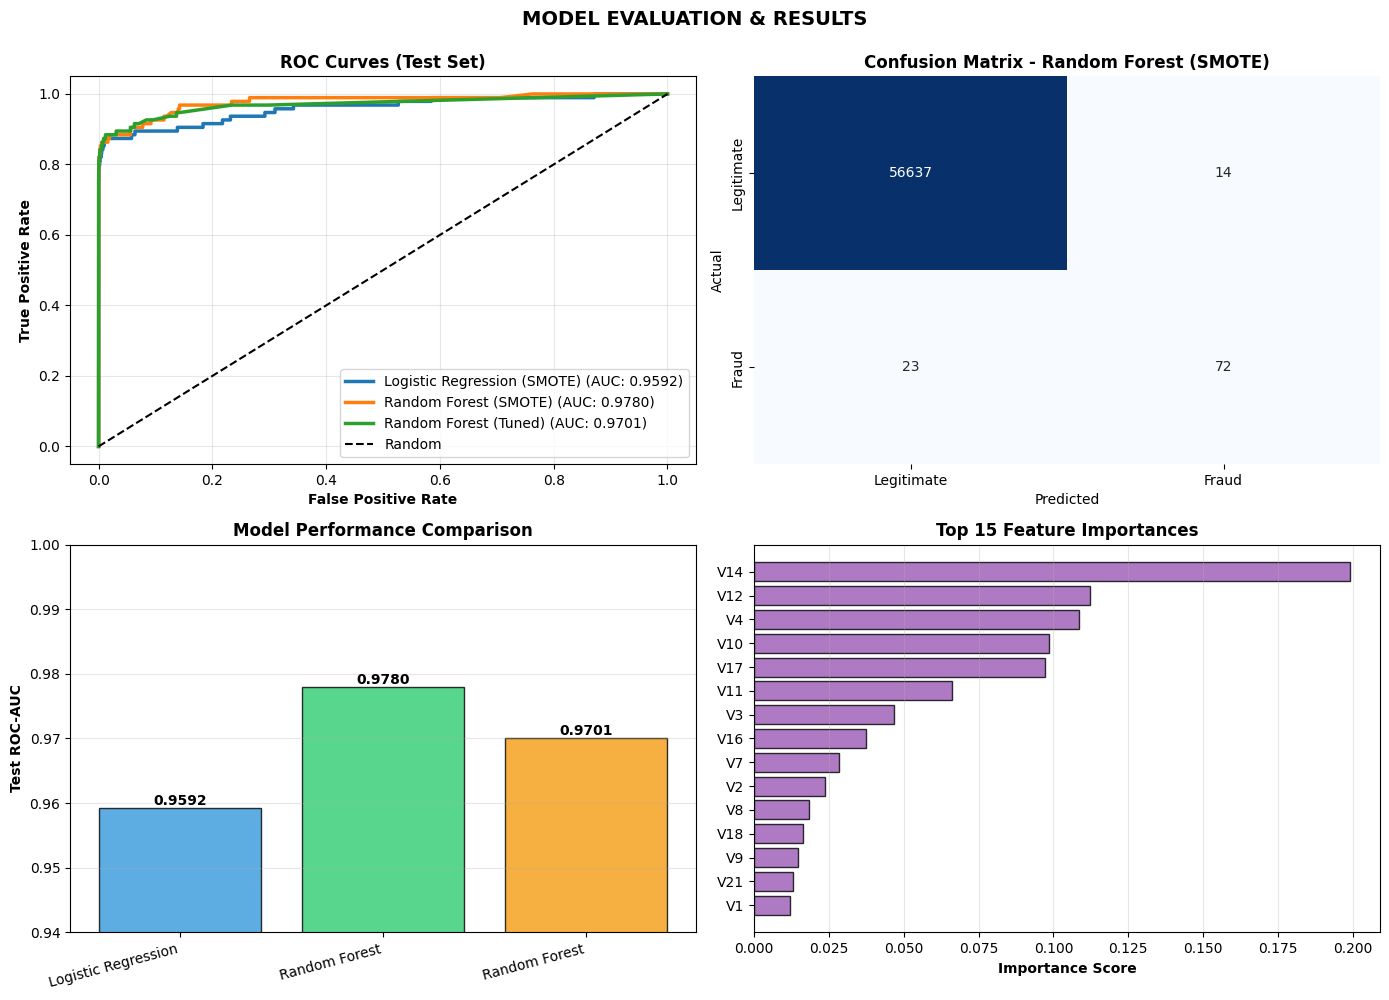


✓ Saved: 02_model_evaluation.png

PIPELINE COMPLETE!


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ROC Curves
for r in results:
    fpr, tpr, _ = roc_curve(y_test, r['y_test_proba'])
    axes[0, 0].plot(fpr, tpr, lw=2.5, label=f"{r['name']} (AUC: {r['test_auc']:.4f})")
axes[0, 0].plot([0, 1], [0, 1], 'k--', lw=1.5, label='Random')
axes[0, 0].set_xlabel('False Positive Rate', fontweight='bold')
axes[0, 0].set_ylabel('True Positive Rate', fontweight='bold')
axes[0, 0].set_title('ROC Curves (Test Set)', fontweight='bold', fontsize=12)
axes[0, 0].legend(loc='lower right')
axes[0, 0].grid(alpha=0.3)

# Confusion Matrix (Best Model)
cm = confusion_matrix(y_test, best_result['y_test_pred'])
sns.heatmap(cm, annot=True, fmt='d', ax=axes[0, 1], cmap='Blues', cbar=False,
            xticklabels=['Legitimate', 'Fraud'], yticklabels=['Legitimate', 'Fraud'])
axes[0, 1].set_title(f'Confusion Matrix - {best_result["name"]}', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Actual')
axes[0, 1].set_xlabel('Predicted')

# Model Comparison Bar Chart
model_names = [r['name'].split('(')[0].strip() for r in results]
auc_scores = [r['test_auc'] for r in results]
bars = axes[1, 0].bar(range(len(results)), auc_scores, color=['#3498db', '#2ecc71', '#f39c12'], alpha=0.8, edgecolor='black')
axes[1, 0].set_xticks(range(len(results)))
axes[1, 0].set_xticklabels(model_names, rotation=15, ha='right')
axes[1, 0].set_ylabel('Test ROC-AUC', fontweight='bold')
axes[1, 0].set_title('Model Performance Comparison', fontweight='bold', fontsize=12)
axes[1, 0].set_ylim(0.94, 1.0)
for bar, score in zip(bars, auc_scores):
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{score:.4f}', ha='center', va='bottom', fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Feature Importance (Best Model)
if hasattr(best_result['model'], 'feature_importances_'):
    importances = best_result['model'].feature_importances_
    top_indices = np.argsort(importances)[-15:]
    top_features = [feature_cols[i] for i in top_indices]
    top_importances = importances[top_indices]
    axes[1, 1].barh(range(len(top_features)), top_importances, color='#9b59b6', alpha=0.8, edgecolor='black')
    axes[1, 1].set_yticks(range(len(top_features)))
    axes[1, 1].set_yticklabels(top_features)
    axes[1, 1].set_xlabel('Importance Score', fontweight='bold')
    axes[1, 1].set_title('Top 15 Feature Importances', fontweight='bold', fontsize=12)
    axes[1, 1].grid(axis='x', alpha=0.3)

plt.suptitle('MODEL EVALUATION & RESULTS', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('02_model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ Saved: 02_model_evaluation.png")

print(f"\n{'='*70}")
print("PIPELINE COMPLETE!")
print(f"{'='*70}")
